In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as re
import feedparser
pd.options.display.max_columns = None

In [3]:
request = re.get("https://justjoin.it/api/offers")
data = request.json()
df = pd.DataFrame.from_dict(data)

In [4]:
contract_type_column = lambda data: data[0]["type"]
salary_from_type_column = lambda data: data[0]["salary"]["from"] if data[0]["salary"] is not None else data[0]["salary"]
salary_to_type_column = lambda data: data[0]["salary"]["to"] if data[0]["salary"] is not None else data[0]["salary"]
currency_type_column = lambda data: data[0]["salary"]["currency"] if data[0]["salary"] is not None else data[0]["salary"]


df["contract_type"] = df["employment_types"].apply(contract_type_column)
df["salary_from"] = df["employment_types"].apply(salary_from_type_column)
df["salary_to"] = df["employment_types"].apply(salary_to_type_column)
df["curr"] = df["employment_types"].apply(currency_type_column)

df.drop(columns=["employment_types"], inplace=True)

In [5]:
df["skill_types"] = df["skills"].apply(lambda x: [i["name"] for i in x])
df["skill_values"] = df["skills"].apply(lambda x: [i["level"] for i in x])

df.drop(columns=["skills"], inplace=True)

In [6]:
df.head()

,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,company_size,experience_level,latitude,longitude,published_at,remote_interview,open_to_hire_ukrainians,id,company_logo_url,remote,contract_type,salary_from,salary_to,curr,skill_types,skill_values
0,Golang Developer with Kubernetes,Grzybowska,Warszawa,PL,"Grzybowska, Warszawa",go,remote,HireOne IT Recruitment,http://hire1.it,40,senior,52.2346688,20.9907818,2022-03-27T14:00:13.569Z,True,False,hireone-it-recruitment-golang-developer-with-k...,https://bucket.justjoin.it/offers/company_logo...,True,b2b,25500.0,34000.0,pln,"[Kubernetes, REST API, Golang]","[3, 4, 4]"
1,Senior Python Core Developer,Zajecza 15,Warszawa,PL,"Zajecza 15, Warszawa",python,partly_remote,StratsLab,https://www.stratslab.com/,11-50,senior,52.2381841,21.0251211,2022-03-27T14:00:13.569Z,True,False,stratslab-senior-python-core-developer,https://bucket.justjoin.it/offers/company_logo...,False,b2b,20000.0,28000.0,pln,"[Rust, C++, Python]","[1, 1, 4]"
2,"Sr Software Engineer, Full Stack",-,Gorzów Wielkopolski,PL,"-, Gorzów Wielkopolski",javascript,remote,PubNub,http://www.pubnub.com,100 - 150,senior,52.7325285,15.2369305,2022-03-27T14:00:13.569Z,True,False,pubnub-sr-software-engineer-full-stack-gorzow-...,https://bucket.justjoin.it/offers/company_logo...,True,b2b,21000.0,27000.0,pln,"[TypeScript, SQL, Cloud Platforms]","[4, 4, 4]"
3,"Junior Software Engineer, Frontend",Fabryczna 20A,Kraków,PL,"Fabryczna 20A, Kraków",javascript,remote,SmartRecruiters Inc.,https://www.smartrecruiters.com/,500,junior,50.0655329,19.9753659,2022-03-27T14:00:13.569Z,True,False,smartrecruiters-inc-junior-frontend-software-e...,https://bucket.justjoin.it/offers/company_logo...,True,permanent,8000.0,12000.0,pln,"[JavaScript, CSS, HTML]","[2, 3, 3]"
4,PMO Specialist (junior/regular),Al. Jerozolimskie 146D,Warszawa,PL,"Al. Jerozolimskie 146D, Warszawa",pm,remote,Nowa Era Sp. z o.o.,https://www.nowaera.pl,<500,mid,52.214113,20.9543949,2022-03-27T14:00:13.569Z,True,False,nowa-era-sp-z-o-o-pmo-specialist-junior-regular,https://bucket.justjoin.it/offers/company_logo...,True,b2b,NaN,NaN,None,"[English, SharePoint, MS Excel]","[4, 4, 4]"


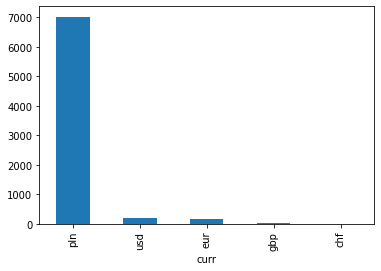

In [7]:
df.groupby("curr").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()

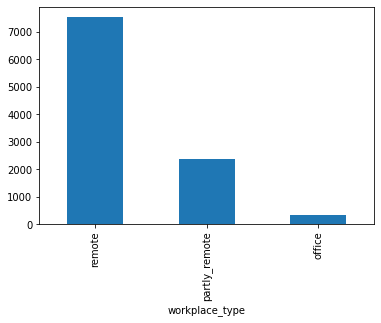

In [8]:
df.groupby("workplace_type").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()

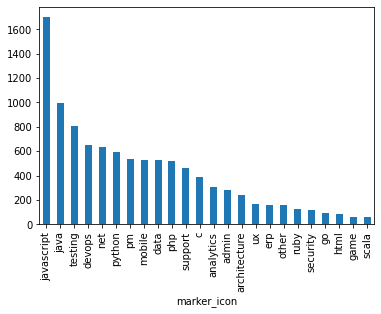

In [9]:
df.groupby("marker_icon").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()

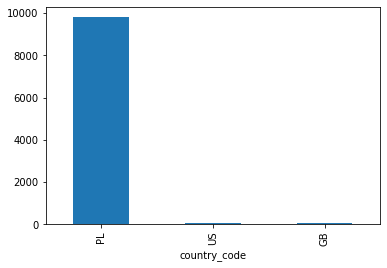

In [10]:
df.groupby("country_code").count()["id"].sort_values(ascending=False).head(3).plot(kind="bar")
plt.show()

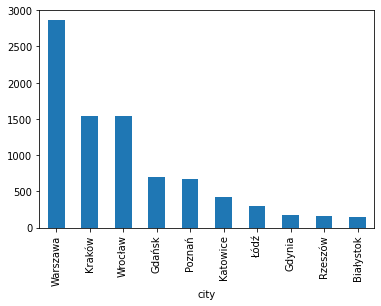

In [11]:
df.groupby("city").count()["id"].sort_values(ascending=False).head(10).plot(kind="bar")
plt.show()

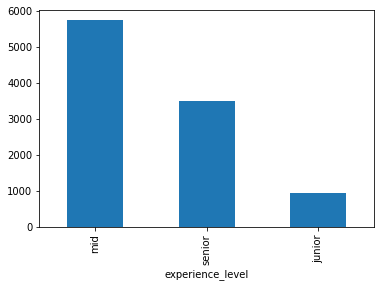

In [12]:
df.groupby("experience_level").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()


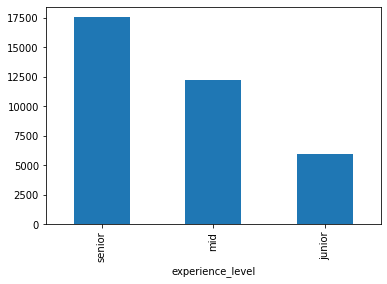

In [13]:
df.groupby("experience_level").mean()["salary_from"].sort_values(ascending=False).plot(kind="bar")
plt.show()

In [14]:
df.to_csv("salaries.csv", index=False)